# 注意力机制
* 卷积、全连接、池化层都只考虑不随意线索
* 注意力机制则显示的考虑随意线索
  * 随意线索被称之为查询(query)
  * 每个输入是一个值(value)和不随意线索(key)的对
  * 通过注意力池化层来有偏向性的选择某些输入

<img src='./image/attentionMechanism.jpg' alt='attentionMechanism' width=400><br>

时间复杂度$O(knT)$<br>
## 非参注意力池化层
* 给定数据$(x_i, y_i), i=1,...,n$
* 平均池化是最简单的方案：$f(x) = \frac 1 n \sum _{i} y_i$,其中x是query
* 更好的方案是60年代提出的Nadaraya-Watson核回归
$$f(x)= \sum ^n _{i=1} \frac {K(x - x_i)} {\sum ^n_{j=1} K(x - x_j)} y_i$$
其中$x$为query，$x_j$ 为key $y_i$为value，K为kernel<br>
使用高斯核$K(u) = \frac {1}{\sqrt {2\pi} } \exp (- \frac {u^2} 2)$<br>
那么
$$f(x) = \sum ^n _{i=1} \frac {\exp (- \frac 1 2 (x - x_i)^2)} {\sum ^n_{j=1} \exp (- \frac 1 2 (x - x_j)^2)} y_i \\
  = \sum^n _{i=1} softmax(- \frac 1 2 (x-x_i)^2) y_i$$
相当于给每个q和k求权重后乘v后相加<br>

## 参数化注意力机制
在之前的基础上引入可以学习的w，这里的w是一个标量
$$f(x) = \sum^n _{i=1} softmax(- \frac 1 2 ((x-x_i)w)^2) y_i$$

## 注意力pooling: Nadaraya-Watson核回归

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

生成数据集

In [ ]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x): # 真实的函数
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

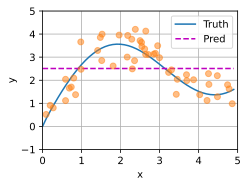

In [ ]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

y_hat = torch.repeat_interleave(y_train.mean(), n_test) # 在指定维度重复n次
plot_kernel_reg(y_hat)

非参数注意力汇聚

(None, torch.Size([50]), torch.Size([50, 50]), torch.Size([50]))

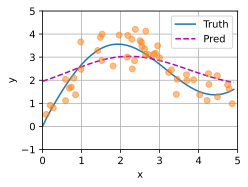

In [6]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat), x_train.shape, X_repeat.shape, y_train.shape

注意力权重

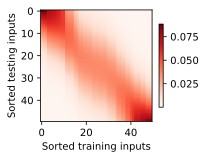

In [7]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

带参数的注意力汇聚

In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

使用小批量矩阵乘法来计算小批量数据中的加权平均值

In [ ]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
# 对batch的每一组做矩阵乘法
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)), weights.shape, values.shape

(tensor([[[ 4.5000]],
 
         [[14.5000]]]),
 torch.Size([2, 10]),
 torch.Size([2, 10]))

带参数的注意力汇聚

In [11]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape(
            (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

将训练数据集转换为键和值

In [ ]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
# mask = (1 - torch.eye(n_train)).type(torch.bool) 构造出一个除了对角线都为1的矩阵
# 目的在于消除所有非自身的组合
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
X_tile.shape, 

(torch.Size([50, 50]),)

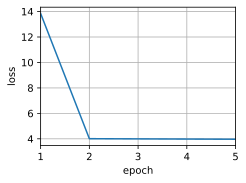

In [19]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

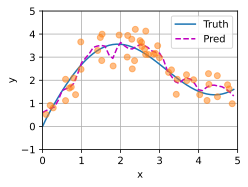

In [20]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

曲线在注意力权重较大的区域变得更不平滑

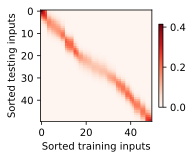

In [15]:
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')